In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from binconvfm.models.binconv import BinConvForecaster
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
class Seq2SeqDataset(Dataset):
    def __init__(self, seq, input_len=24, output_len=5):
        self.input_len = input_len
        self.output_len = output_len
        self.seq = torch.tensor(seq, dtype=torch.float32)
        self.seq = self.seq.unsqueeze(-1)
        self.length = len(seq) - input_len - output_len + 1

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        input_seq = self.seq[idx: idx + self.input_len]
        target_seq = self.seq[idx + self.input_len: idx + self.input_len + self.output_len]
        return input_seq, target_seq

In [3]:
x_space = np.linspace(0, 100, 1000)
seq = np.sin(x_space) + np.random.randn(1000) * 0.1

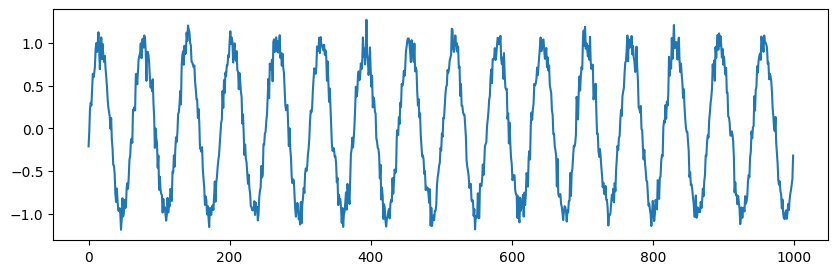

In [4]:
plt.figure(figsize=(10, 3))
plt.plot(seq)
plt.show()

In [5]:
input_len = 100
output_len = 50
batch_size = 256
n_samples = 100
train_ds = Seq2SeqDataset(seq, input_len, 1)  # for binconv, like for decoder-only models output_len = 1
test_ds = Seq2SeqDataset(seq, input_len, output_len)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
pred_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [6]:
data = next(iter(train_dataloader))

In [7]:
data[1].shape

torch.Size([256, 1, 1])

In [8]:
model = BinConvForecaster(num_epochs=5, n_samples=1, context_length=input_len, num_filters_2d=input_len,
                          num_filters_1d=input_len, num_bins=256, min_bin_value=-1.5, max_bin_value=1.5, num_blocks=1,
                          dropout=0.0)
model.fit(train_dataloader, val_dataloader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/andreichernov/Documents/Personal/research/foundation TS/binconvfm/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/andreichernov/Documents/Personal/research/foundation TS/binconvfm/venv/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /Users/andreichernov/Documents/Personal/research/foundation TS/binconvfm/notebooks/checkpoints exists and is not empty.

  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | BinConv | 36.2 K | train
-------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/andreichernov/Documents/Personal/research/foundation TS/binconvfm/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/andreichernov/Documents/Personal/research/foundation TS/binconvfm/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [9]:
model.evaluate(test_dataloader)

/Users/andreichernov/Documents/Personal/research/foundation TS/binconvfm/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          crps             0.058664992451667786
          mase              0.9379003047943115
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'mase': 0.9379003047943115, 'crps': 0.058664992451667786}

In [10]:
pred = model.predict(pred_dataloader, horizon=output_len)
pred[0].shape

/Users/andreichernov/Documents/Personal/research/foundation TS/binconvfm/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

torch.Size([256, 1, 50, 1])

In [11]:
pred[0].shape

torch.Size([256, 1, 50, 1])

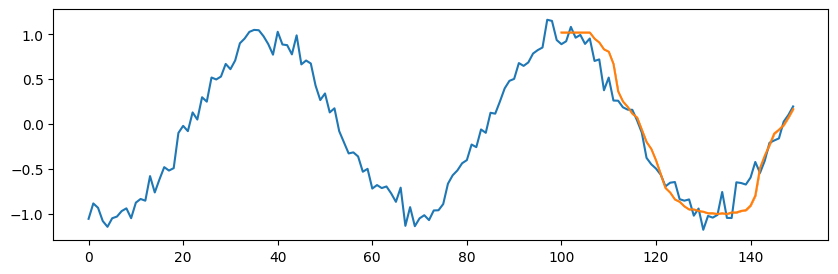

In [12]:
idx0 = torch.randint(len(pred), (1,)).item()
idx1 = torch.randint(len(pred[idx0]), (1,)).item()
input_seq, target_seq = list(pred_dataloader)[idx0]
input_seq, target_seq = input_seq[idx1, :, -1], target_seq[idx1, :, -1]
q = torch.tensor([0.01, 0.5, 0.99])
pred_seq = torch.quantile(pred[idx0][idx1, :, :, -1], q=q, dim=0)

plt.figure(figsize=(10, 3))
plt.plot(range(input_len + output_len), torch.concat([input_seq, target_seq]))
plt.plot(range(input_len, input_len + output_len), pred_seq[1])
plt.fill_between(range(input_len, input_len + output_len), pred_seq[0], pred_seq[2], alpha=0.5, color='tab:orange')
plt.show()